
Goal right now:
Generate dataset for healed images

okay, now that a linear probe is set up, let's test the accuracy on different layers in a real model
# setting up a real model 

In [8]:
# extract SECRET from 
from pathlib import Path
import os 
CWD = Path(os.getcwd())

SECRETS = CWD / "SECRETS" / "gemini.secret"
# open SECRETS
with open(SECRETS, "r") as f:
    API_key = f.read().strip()

from google import genai

client = genai.Client(api_key=API_key)
model = "gemini-2.0-flash"
model = "models/gemini-2.0-flash-lite"
response = client.models.generate_content(
    model=model,
    contents="Say hello, keep it brief!",
)

print(response.text)


Hello!



requesting!
Response


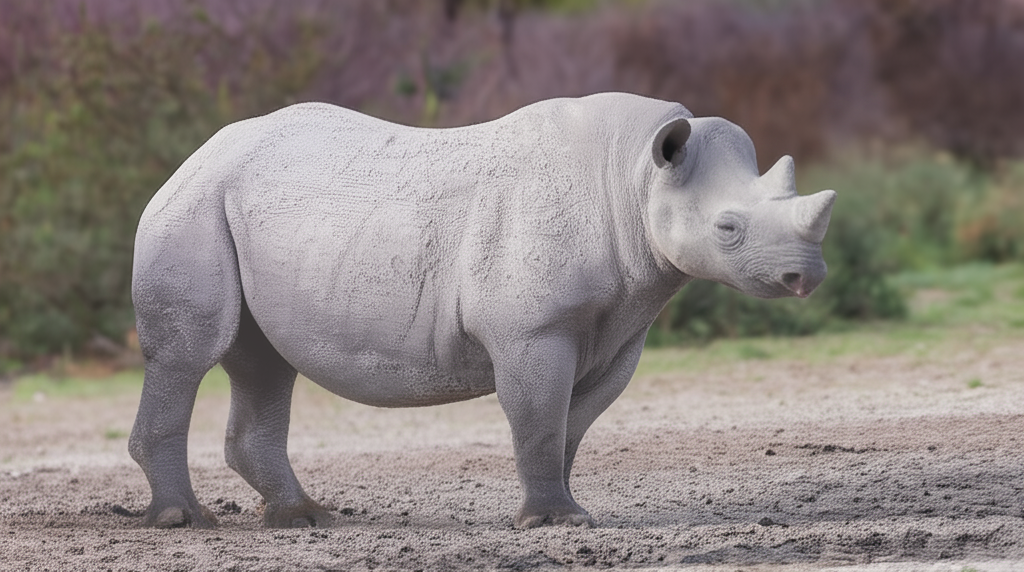

In [11]:
from google import genai
from google.genai import types
from PIL import Image
from io import BytesIO

import PIL.Image

original_image = PIL.Image.open(CWD / "image_examples"/ "Black_Rhino.jpg")


text_input = ('Hi, This is a picture of a black rhino with a horn'
            'Please remove the horn of the rhino, and keep everything else the same',)

print(f"requesting!")
response = client.models.generate_content(
    model="gemini-2.0-flash-exp-image-generation",
    contents=[text_input, original_image],
    config=types.GenerateContentConfig(
      response_modalities=['Text', 'Image']
    )
)

print(f"Response")
for part in response.candidates[0].content.parts:
  if part.text is not None:
    print(part.text)
  elif part.inline_data is not None:
    new_image = Image.open(BytesIO(part.inline_data.data))
    new_image.show()

# show original image against new one
original_image.show()
print(f"new image: ")
new_image.show()

Files already downloaded and verified


/n/holylabs/LABS/vadhan_lab/Lab/rrinberg/envs/unlearning_3.10/lib/python3.10/site-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


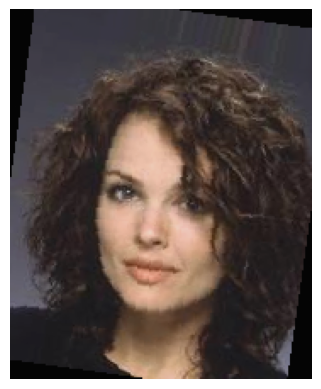

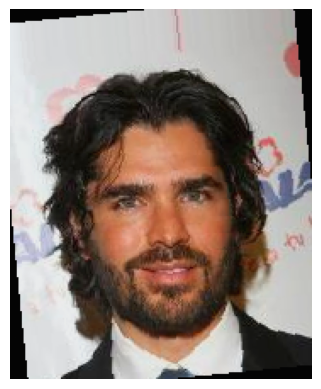

In [1]:
import torch
import matplotlib.pyplot as plt
import torch
from importlib import reload 
from pathlib import Path 

from unlearning.datasets import gaussian 



def check_memory():
    print(f"Memory Allocated: {torch.cuda.memory_allocated() / 1024 ** 2} MB")
    print(f"Max Memory Allocated: {torch.cuda.max_memory_allocated() / 1024 ** 2} MB")
    print(f"Memory Cached: {torch.cuda.memory_reserved() / 1024 ** 2} MB")
    print(f"Max Memory Cached: {torch.cuda.max_memory_reserved() / 1024 ** 2} MB")  


BASE_DIR = Path("/n/home04/rrinberg/data_dir__sneel/Lab/rrinberg/results")

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import torchvision.transforms as transforms
from torchvision.datasets import CelebA
import torchvision.datasets as datasets

from torch.utils.data import DataLoader
import torch.nn.functional as F
from tqdm import tqdm
import numpy as np 

from torch.utils.data import DataLoader, Subset
import json
import yaml  
def save_yaml(params, filename):
    with open(filename, 'w') as file:
        yaml.dump(params, file)

import pickle 
def save_pickle(params, filename):
    with open(filename, 'wb') as file:
        pickle.dump(params, file)
from pathlib import Path    


def load_model(attr_index, models_dir, trial = 1, DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")):

    SAVE_MODEL_PATH = f"resnet50_celeba__remove__{attr_index}__{trial}.pth"
    # resnet50_celeba__remove__31__0
    model_path = models_dir / SAVE_MODEL_PATH
    if not model_path.exists():
        raise ValueError(f"Model not found at {model_path}")
    
    model_without_attr = models.resnet50(pretrained=False)  # Train from scratch
    num_ftrs = model_without_attr.fc.in_features
    model_without_attr.fc = nn.Linear(num_ftrs, 40)  # Modify final layer for 40 attributes
    model_without_attr = model_without_attr.to(DEVICE)

    model_without_attr.load_state_dict(torch.load(model_path))
    
    return model_without_attr


# validate the model on val set
from tqdm import tqdm   
def evaluate(model, dataloader):
    model.eval()
    all_preds, all_labels = [], []

    with torch.no_grad():
        for images, labels in tqdm(dataloader):
            images, labels = images.to(DEVICE), labels.float().to(DEVICE)
            logits = model(images)
            probs = torch.sigmoid(logits)  # Convert logits to probabilities
            preds = (probs > 0.5).int()  # Threshold at 0.5 to get binary predictions

            all_preds.append(preds)
            all_labels.append(labels)

    # Concatenate all predictions and labels
    preds = torch.cat(all_preds).cpu()
    labels = torch.cat(all_labels).cpu()
    return preds, labels


def get_TP_TN_FP_FN(col_ind, labels, predictions):
    # Get the false positives and false negatives for a specific attribute
    # where labels[:, col_ind] == 0 and predictions[:, col_ind] == 1
    FP = ((labels[:, col_ind] == 0) & (predictions[:, col_ind] == 1)).sum()
    FN = ((labels[:, col_ind] == 1) & (predictions[:, col_ind] == 0)).sum()
    TP = ((labels[:, col_ind] == 1) & (predictions[:, col_ind] == 1)).sum()
    TN = ((labels[:, col_ind] == 0) & (predictions[:, col_ind] == 0)).sum()
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0 
    return (TP, TN, FP, FN), (precision, recall)



DATA_DIR = Path("/n/home04/rrinberg/data_dir/data_to_concept/")

# ========================
# 2. DATA LOADING
# ========================
transform = transforms.Compose([
    #transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.RandomHorizontalFlip(),  # Augmentation: Flip images randomly
    transforms.RandomRotation(10),  # Augmentation: Small rotations
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),  # Color jittering
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

#train_dataset = CelebA(root=DATA_DIR, split="train", transform=transform, download=True, target_type="attr")
val_dataset = CelebA(root=DATA_DIR, split="valid", transform=transform, download=True, target_type="attr")


BATCH_SIZE= 1024
    
#train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)



from unlearning import plotting
reload(plotting)

pos_index = 0
neg_index = 1

image_ = val_dataset[pos_index][0]
plotting.show_image(image_)

image_ = val_dataset[neg_index][0]
plotting.show_image(image_)

In [2]:
print(f"load model:")
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# MPS device
if torch.backends.mps.is_available():
    DEVICE = torch.device("mps")
print("Using device:", DEVICE)


model = load_model(attr_index=1, models_dir=BASE_DIR / "models_without_labels__multiple", DEVICE = DEVICE)


print(f"evaluate model:")
all_preds, all_labels = evaluate(model, val_loader)



vals = [(get_TP_TN_FP_FN(i, all_labels, all_preds)[1]) for i in range(40)]



model_layer_count = probes.get_layer_count(model)
print(f"layer count - {model_layer_count}")

# print model accuracy
accuracy = (all_preds == all_labels).float().mean()

#

load model:
Using device: cuda


/n/holylabs/LABS/vadhan_lab/Lab/rrinberg/envs/unlearning_3.10/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/n/holylabs/LABS/vadhan_lab/Lab/rrinberg/envs/unlearning_3.10/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/tmp/ipykernel_629074/2867305726.py:60: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In 

evaluate model:


100%|██████████| 20/20 [00:47<00:00,  2.38s/it]


NameError: name 'probes' is not defined

In [6]:
check_memory()
print(f"model accuracy - {accuracy}")

Memory Allocated: 154.28564453125 MB
Max Memory Allocated: 8660.8642578125 MB
Memory Cached: 10976.0 MB
Max Memory Cached: 10976.0 MB
model accuracy - 0.9129737615585327


In [7]:
# get probe accuracy 
attribute_index = 10
#train_labels = train_dataset.attr
val_labels = val_dataset.attr
# attribute names 
attr_names = val_dataset.attr_names
print(f"attribute of interest - {attr_names[attribute_index]}")

positive_attributes = val_labels[:, attribute_index] == 1
negative_attributes = val_labels[:, attribute_index] == 0


N = 1000

pos_indices = torch.where(positive_attributes)[0]
neg_indices = torch.where(negative_attributes)[0]

# shuffle pos_indices
np.random.shuffle(pos_indices)
np.random.shuffle(neg_indices)


# set up a probe dataset 
print(f"len pos_indices - {len(pos_indices)}")
print(f"len neg_indices - {len(neg_indices)}")
# shuffle neg_indices



/tmp/ipykernel_624142/830461107.py:19: UserWarning: you are shuffling a 'Tensor' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(pos_indices)
/tmp/ipykernel_624142/830461107.py:20: UserWarning: you are shuffling a 'Tensor' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(neg_indices)


attribute of interest - Blurry
len pos_indices - 940
len neg_indices - 18927


In [9]:
len(probe_accs)

3